In [1]:
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/image-restoration/pic/barraxx.bmp
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/image-restoration/lenna.jpg

--2020-10-07 16:40:37--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/image-restoration/pic/barraxx.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600056 (586K) [image/bmp]
Saving to: ‘barraxx.bmp.2’

barraxx.bmp.2       100%[===================>] 585.99K  --.-KB/s    in 0.09s   

2020-10-07 16:40:38 (6.41 MB/s) - ‘barraxx.bmp.2’ saved [600056/600056]

--2020-10-07 16:40:38--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/image-restoration/lenna.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8145

Imports y funciones auxiliares

In [35]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2,fftshift,ifft2,ifftshift

def fft_c(x):
    return fftshift(fft2(x))
def ifft_c(x):
    return ifft2(ifftshift(x))
def get_gaussian_kernel(size,sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    kernel /= np.sum(kernel)
    return kernel

def get_delta(img):
    delta = np.zeros_like(img).astype(np.float64)
    delta[delta.shape[0]//2,delta.shape[1]//2] = 1
def get_expanded_kernel(img2conv,kernel):
    delta = np.zeros_like(img2conv).astype(np.float64)
    delta[delta.shape[0]//2,delta.shape[1]//2] = 1
    conv = cv2.filter2D(src=delta, kernel=kernel, ddepth=-1)
    return conv

def add_noise_to_image(bw_image,mean,std):
    noise = np.random.normal(mean, std, bw_image.shape)
    noisy_img = bw_image + noise
    noisy_img_clipped = np.clip(noisy_img, 0, 255)  # we might get out of bounds due to noise
    return noisy_img_clipped,noise

def productoftransfersinfreqdom(img,kernel):
    true_kernel = get_expanded_kernel(img,kernel)
    product_without_shift = fft2(img)*fft2(true_kernel)
    product_c = fftshift(product_without_shift) 
    return np.real(fftshift(ifft_c(product_c)))
    
def restoreByInverseFilter(degraded,kernel):
    expanded_kernel = get_expanded_kernel(degraded,kernel)
    K = fft2(expanded_kernel)
    # I = original(f), K = kernel(f), G = degraded(f)
    G = fft2(degraded)
    # OJO CON PONER 2 SHIFTS, solo debe haber 1!
    I_c = fftshift(G/(K))
    # asumimos que G= I*K <=> I=G/K
    return np.real(fftshift(ifft_c(I_c)))

def modsquaredF(x):
    return np.square(np.abs(fft2(x)))
def modsquare(x):
     return np.square(np.abs(x))
def restoreByWiener(original,degraded,kernel,noise):
    h = get_expanded_kernel(original,kernel) 
    H = fft2(h) # no centrado
    G = fft2(degraded) # no centrado
    S_n = modsquaredF(noise) # no centrado
    S_f = modsquaredF(original) # no centrado
    # ojo, los np.corrcoef son de tipo pearson, por eso antes no andaba de 1
    W = np.conj(H)/( modsquare(H)+ S_n/S_f) # no centrado
    F_hat_c = fftshift(W*G) # ahora esta centrado
    # fftshift(W)*fftshift(G) = fftshift(W*G)!!!
    f = np.real(fftshift(ifft_c(F_hat_c)))
    return f

def plot_images(original,txt1,degraded,txt2,restored,txt3):
    fig=plt.figure(figsize=(14, 10))
    fig.add_subplot(1, 3, 1)
    plt.title(txt1)
    plt.imshow(original,cmap='gray')
    fig.add_subplot(1, 3, 2)
    plt.title(txt2)
    plt.imshow(blurred_plus_noise,cmap='gray')
    fig.add_subplot(1, 3, 3)
    plt.title(txt3)
    plt.imshow(restored,cmap='gray')

### Lenna será nuestra imagen de prueba

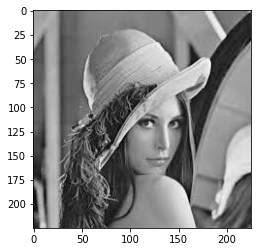

In [3]:
lenna = cv2.imread('lenna.jpg')
bw_lenna = cv2.cvtColor(lenna,cv2.COLOR_BGR2GRAY)
plt.imshow(bw_lenna,cmap='gray')

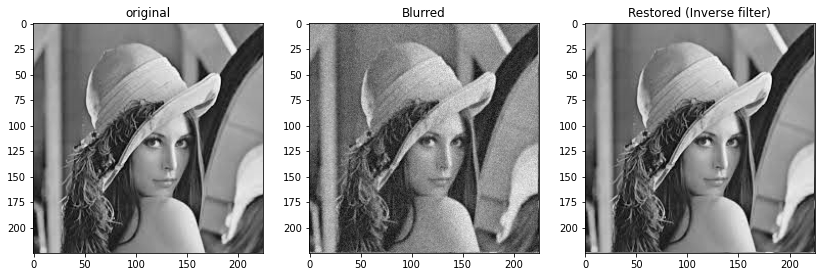

In [80]:
lpass1=(1/9)*np.array([[1,1,1],[1,1,1],[1,1,1]]);
lpass2=(1/16)*np.array([[1,1,1],[1,8,1],[1,1,1]])
kernel = get_gaussian_kernel(size=3,sigma=0.5)
id_kernel = np.array([[0,0,0],[0,1,0],[0,0,0]])

#aca elegimos que kernel probar
kernel2test = kernel

original = bw_lenna.copy()
#blurred = cv2.filter2D(bw_lenna,-1,kernel2test) 
# OJO, NO ES LO MISMO hacer las cosas convolucion que hacer las cosas en F.
# En la teoria anda, en la practica no (filter2D vs ffts).
# A veces tira errores el codigo al restaurar, imagino que es por los 
# 0 de la transferencia que divide en cuyo caso hay que regularizar

blurred = productoftransfersinfreqdom(original,kernel2test)
restored = restoreByInverseFilter(blurred,kernel2test)
plot_images(original,"original",blurred,"Blurred",restored,"Restored (Inverse filter)")

## Imagen con ruido 

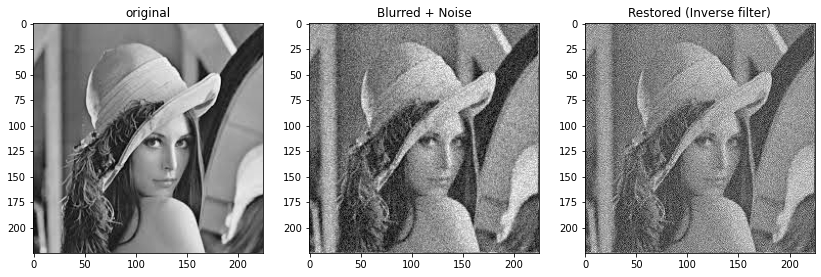

In [81]:
blurred_plus_noise, noise = add_noise_to_image(blurred,mean=0,std= 20)
restored = restoreByInverseFilter(blurred_plus_noise,kernel2test)
#restored = restoreByInverseFilter(blurred,kernel2test)
plot_images(original,"original",blurred_plus_noise,"Blurred + Noise",restored,"Restored (Inverse filter)")

Se observó que dependiendo del kernel a probar, a veces la imagen restaurada empeora significativamente. Hay una tendencia a que mientras los kernel más se parezcan a una delta, la imagen restaurada mejora significativamente

## Filtro de Wiener

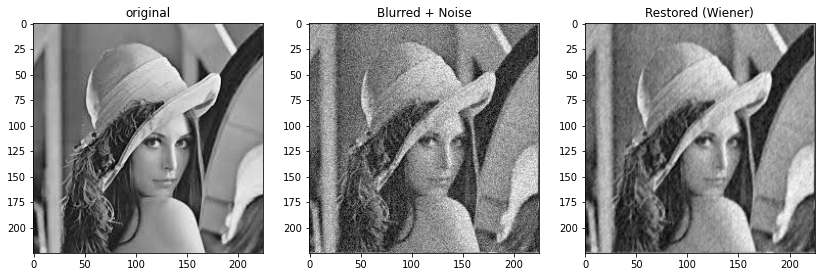

In [82]:
restored_wienier = restoreByWiener(original,blurred_plus_noise,kernel2test,noise)
plot_images(original,"original",blurred_plus_noise,"Blurred + Noise",restored_wienier,"Restored (Wiener)")

## Mediciones

In [83]:
def mse(original_hat,original):
    error = original_hat - original;
    return np.mean(np.square(error))

def nmse(original,procesada):
    var_erro=(np.std(original-procesada))**2
    var_orig=(np.std(original))**2
    norm_mse=100*(var_erro/var_orig)
    return norm_mse        

bw_my_image = original
degraded_my_image = blurred_plus_noise
restored_my_image = restored_wienier

SNR_improvement = nmse(bw_my_image,degraded_my_image)/nmse(bw_my_image,restored_my_image)
SNR_improvement_dB =10*np.log10(SNR_improvement) 

print("SNR_improvement = ",SNR_improvement, "SNR_improvement_dB= ",SNR_improvement_dB)

SNR_Restored_dB=10*np.log10(np.std(restored_my_image)**2/np.std(noise)**2)
print("SNR_Restored_dB =",SNR_Restored_dB)
SNR_Degraded=10*np.log10(np.std(degraded_my_image)**2/np.std(noise)**2)
print("SNR_Degraded_dB =",SNR_Degraded)

std_err_Restored = np.std(restored_my_image - bw_my_image)
print("std_err_Restored =",std_err_Restored)
std_err_Degraded = np.std(degraded_my_image - bw_my_image)
print("std_err_Degraded =",std_err_Degraded)


DMSE = mse(degraded_my_image,bw_my_image)
print("DMSE = ", DMSE)

RMSE = mse(restored_my_image,bw_my_image)
print("RMSE = ", RMSE)

SNR_restored_original = 10*np.log10( (np.max(bw_my_image))/RMSE)

print("SNR_restored_original =",SNR_restored_original)


SNR_improvement =  1.9350504051714215 SNR_improvement_dB=  2.866922822245402
SNR_Restored_dB = 7.350132955937746
SNR_Degraded_dB = 8.07447708660135
std_err_Restored = 20.467615431428424
std_err_Degraded = 28.4716993785642
DMSE =  810.6494235519555
RMSE =  418.93501990808073
SNR_restored_original = -2.437487647774642
